# Index
+ [Load data](#load-data)
+ [In-set similarity distributions](#in-set-similarity)
+ [Out-of-set similarity and inference](#out-of-set-similarity)
     + [batman](#batman)
     + [lexus](#lexus)
     + [duff](#duff)

### load data

In [1]:
### force keras to use CPU instead of GPU, leaving GPU memory available for terminal
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import h5py
from sklearn.metrics.pairwise import cosine_similarity

main_path = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
src_path = os.path.join(main_path, 'src')

In [3]:
%cd $src_path

/Users/dio/insight/logohunter/src


In [4]:
from litw_features import extract_litw_features, extract_litw_logos
import logos
import similarity
import utils
model, preprocess_input, input_shape = utils.load_extractor_model(flavor=0)

Using TensorFlow backend.


Loaded InceptionV3 feature extractor in 27.22sec


Imported InceptionV3 model (truncated before Dense layers). Explore what happens changing input shape and dropping the last inception blocks - see [here](https://github.com/keras-team/keras/issues/9460#issuecomment-370736493) for simple summary of end of each inception layer

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
[ (i, model.layers[i].name, model.layers[i].output_shape[-1]) for i in range(len(model.layers))
 if model.layers[i].name.startswith('mixed')]

[(40, 'mixed0', 256),
 (63, 'mixed1', 288),
 (86, 'mixed2', 288),
 (100, 'mixed3', 768),
 (132, 'mixed4', 768),
 (164, 'mixed5', 768),
 (196, 'mixed6', 768),
 (228, 'mixed7', 768),
 (248, 'mixed8', 1280),
 (276, 'mixed9_0', 768),
 (279, 'mixed9', 2048),
 (307, 'mixed9_1', 768),
 (310, 'mixed10', 2048)]

In [7]:
from keras import Model
model1 = Model(inputs=model.inputs, outputs=model.layers[228].output)
model2 = Model(inputs=model.inputs, outputs=model.layers[248].output)
model3 = Model(inputs=model.inputs, outputs=model.layers[279].output)

In [15]:
path_to_images = os.path.join(main_path, 'data/LogosInTheWild-v2/data_cleaned/voc_format')
### if LITW class directories have spaces in them, rename them
# for folder in os.listdir(path_to_images):
#     folder_path = os.path.abspath(os.path.join(path_to_images, folder))
#     if ' ' in folder_path:
#         os.rename(folder_path, folder_path.replace(' ',''))

In [16]:
all_logos, brand_map = extract_litw_logos('data_all_train.txt', new_path = main_path)

In [17]:
my_preprocess = lambda x: preprocess_input(utils.pad_image(x, input_shape))
img_array = np.array([my_preprocess(el) for el in all_logos[:2]])
pred = model.predict(img_array)
print(img_array.shape, pred.shape)

input_shape = (200,200,3)
my_preprocess = lambda x: preprocess_input(utils.pad_image(x, input_shape))
img_array = np.array([my_preprocess(el) for el in all_logos[:2]])
pred1 = model1.predict(img_array)
pred2 = model2.predict(img_array)
pred3 = model3.predict(img_array)
print(img_array.shape, pred1.shape, pred2.shape, pred3.shape)

(2, 299, 299, 3) (2, 8, 8, 2048)
(2, 200, 200, 3) (2, 10, 10, 768) (2, 4, 4, 1280) (2, 4, 4, 2048)


The different models have different feature sizes: The earliest I decapitate Inception, the simpler it is. Also I reduce the logo size to 200x200: for a logo, one wouldn't care about having a HD version and should be able to see it even at lower resolution.

Pick feature extractor model for rest of notebook. Here I will pick model2, where I drop the last two inception blocks

In [18]:
model = model2

In [19]:
features = utils.features_from_image(all_logos, model, my_preprocess)

## in-set similarity

For logos that are already in the dataset, how good is the cosine similarity with a test input to classify?

Given that we already have the true labels, we should separately check CS with the same class and different class. For example, testing Wells Fargo, we will check how good we are doing with respect to the true wells fargo images, and with respect to all other logos. This will allow us to look at TP/FP/TN/FN and metrics such as precision and recall

In [20]:
# load class names
with open('data_all_classes.txt','r', encoding='utf-8') as f:
    all_classes = [ s.strip('\n') for s in f.readlines() ]

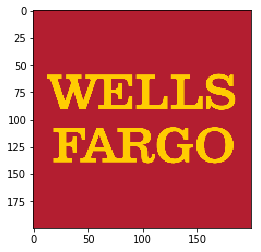

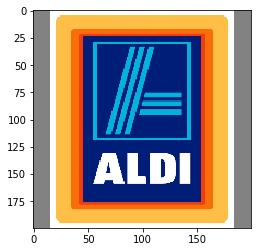

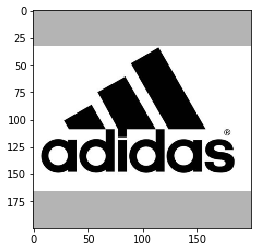

In [21]:
img_data = []
paths = ['test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    img_data.append(img)
    
    plt.imshow(img/255)
    plt.show()

In [22]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cs = cosine_similarity(X = feat_input, Y = features)

Histograms of three different input brands imported above

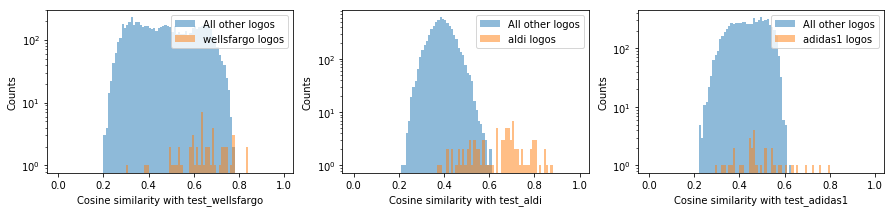

In [23]:
fig, axes = plt.subplots(1,3,figsize=(15,3))
for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]
    

    axes[i_input].hist(cs[i_input][diff_idx], bins=np.arange(0,1,0.01),alpha=0.5, label='All other logos')
    axes[i_input].hist(cs[i_input][same_idx], bins=np.arange(0,1,0.01),alpha=0.5, label='{} logos'.format(brand))
    axes[i_input].set(yscale='log', xlabel='Cosine similarity with test_{}'.format(brand), ylabel='Counts')
    axes[i_input].legend()

We can draw a precision-recall curve by taking the histograms above and using the cosine similarity as our discriminator. This will be more or less good depending on the brand (as seen degree of separation in histograms)

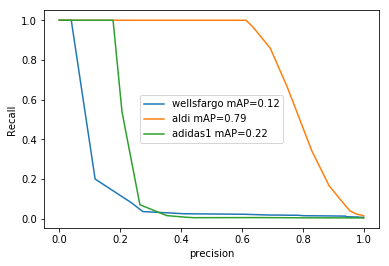

In [24]:
for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]

    tp, fp, tn, fn = [],[],[],[]
    for thr in reversed(np.arange(0,1,0.03)):
        tp.append(len([c for c in cs[i_input][same_idx] if c >= thr ]))
        fp.append(len([c for c in cs[i_input][diff_idx] if c >= thr ]))
        fn.append(len([c for c in cs[i_input][same_idx] if c < thr ]))
        tn.append(len([c for c in cs[i_input][diff_idx] if c < thr ]))
    tp, fp, tn, fn = map(np.array, [tp, fp, tn, fn])
    rec, prec = (tp+0.01)/(tp+fn+0.01), (tp+0.01)/(tp+fp+0.01)
    plt.plot(rec, prec, label = '{} mAP={:.2f}'.format(brand, np.trapz(prec, rec)))
    plt.gca().set(ylabel='Recall', xlabel='precision')
    plt.legend();

We see that Aldi is doing great, while the other two examples are very poor. Let us look at the logos themselves as a function of cosine similarity to try and understand what is going on

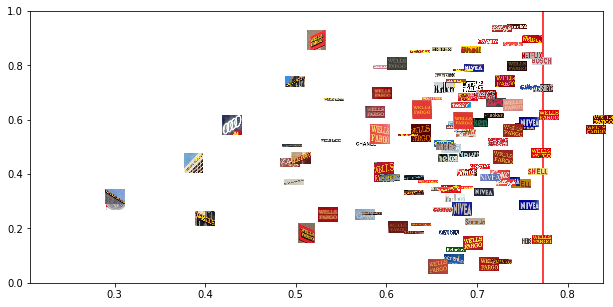

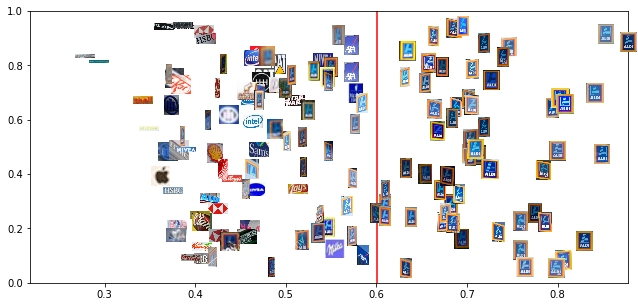

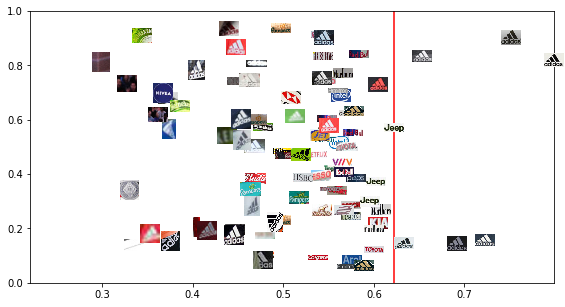

In [25]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]

    artists=[]
    # will plot a sample of the logos, sorted by the cosine similarity
    diff_idx_sort = list(np.argsort(cs[i_input][diff_idx]))
    diff_sample = diff_idx_sort[-10:] + diff_idx_sort[-200::10] + diff_idx_sort[-800:-200:20] 
    for idx in reversed(same_idx+diff_sample):

        img = all_logos[idx]
        
        # reshape all logos to same size
        ih, iw = img.shape[:2]
        h, w = input_shape[:2]
        scale = min(w/iw, h/ih)
        nw, nh = int(iw * scale), int(ih * scale)
        img_data = cv2.resize(img, (nw, nh))

        left = cs[i_input][idx]
        bottom = 0.05 + np.random.rand()*0.9

        ab = AnnotationBbox(OffsetImage((img_data), zoom=0.1), (left, bottom), frameon=False)
        artists.append(plt.gca().add_artist(ab))

    plt.gca().set(xlim=(min(cs[i_input]),max(cs[i_input])), ylim=(0,1), aspect=0.3)
    plt.axvline(np.max(cs[i_input][diff_idx]), c='r');
    plt.gcf().set_size_inches(12,5)
    plt.show()

For Wells Fargo it's easier to see what's going on: many of the logos marked as wells fargo have a different style than the input (for example, written in one-line instead of two). On the other hand, many look the same (maybe with the logo slightly cut off, or with the letters "poppin out" of a sign seen diagonally): those could be addressed by training the feature extractor with more data augmentation (blurrring, shearing, rotating...).

## out-of-set similarity

### batman

YOLO on test11.jpg:
```
logo 0.02 (608, 438) (808, 471)
logo 0.75 (1118, 545) (1183, 630)
logo 0.96 (332, 467) (452, 545)
```

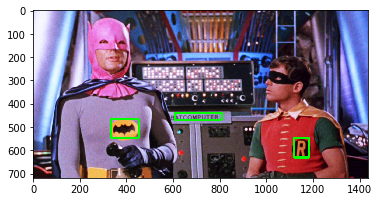

In [26]:
img_yo = cv2.imread('../data/test/sample_in/test11.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(608, 438, 808, 471), (1118, 545, 1183, 630), (332, 467, 452, 545)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

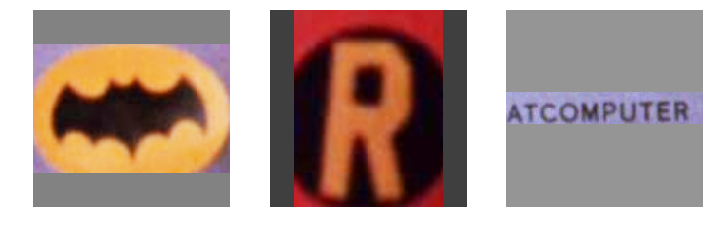

In [27]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

We will test these logos against the batman logo, the robin logo, and the in-set logos we had above

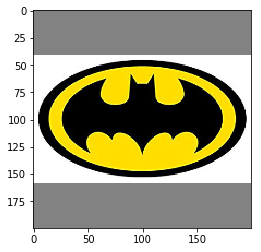

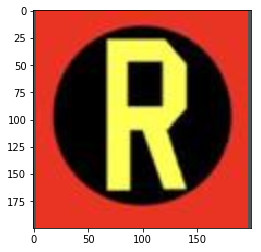

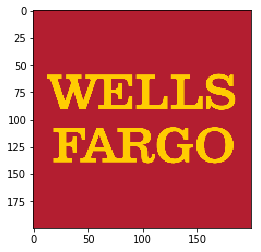

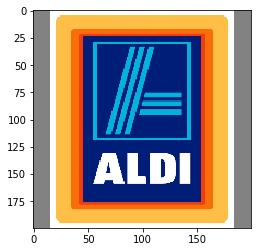

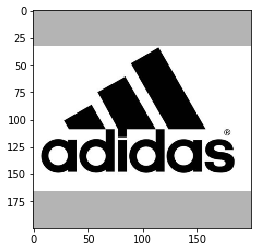

In [28]:
img_data = []
paths = ['test_batman.jpg','test_robin.png','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [29]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

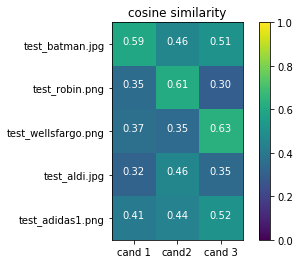

In [30]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand 3'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [31]:
cs1 = cosine_similarity(X = feat_input, Y = features)

test_batman 95% level: 0.562
test_robin 95% level: 0.489
test_wellsfargo 95% level: 0.691
test_aldi 95% level: 0.487
test_adidas1 95% level: 0.555


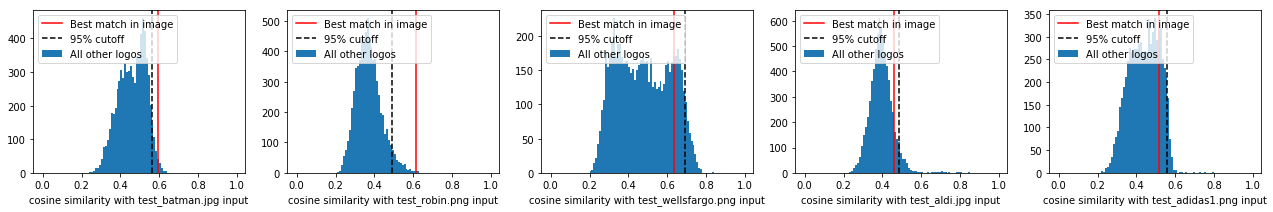

In [32]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos');
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image');
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))

    counts, bins = np.histogram(cs1[iax], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[iax])
    ax.axvline(bins[np.where(cdf < 0.95)][-1], c='k', ls='--', label='95% cutoff')
    print('{} 95% level: {:.3f}'.format(paths[iax].split('.')[0], bins[np.where(cdf < 0.95)][-1]))
    ax.legend(loc='upper left')


We can see that for the two logos that correctly match (Batman, Robin), the best match is on the edge of the cosine similarity distribution: this makes sense, as the recognized logos are more similar to the correct input logos than most other logos in the Logos In The Wild dataset.

For the three remaining input logos who are not in the picture, the best similarity found in the image is typical of the dataset (a randomly chosen logo is a likely as the best match found)

In [33]:
sim_cutoff, cdf_list = [], []
for i in range(len(feat_input)):
    counts, bins = np.histogram(cs1[i], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[i])
    cdf_list.append(cdf)
    sim_cutoff.append(bins[np.where(cdf < 0.95)][-1])

In [34]:
matches, cos_sim = similarity.similar_matches(feat_input, features_cand, sim_cutoff, bins, cdf_list)
matches

Found 2 logos from 2 classes


{0: (0, 0.9885952712100139), 1: (1, 0.9983310152990265)}

In [35]:
new_img = similarity.draw_matches(img_yo, ['batman','robin'], bboxes[::-1], matches)

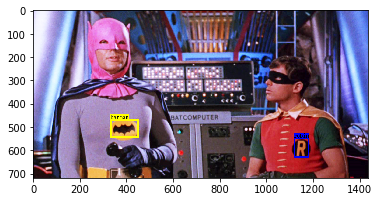

In [36]:
plt.imshow(new_img);

### lexus

YOLO on test9.jpg:
```
logo 0.34 (567, 458) (596, 467)
logo 0.90 (87, 243) (116, 271)
```

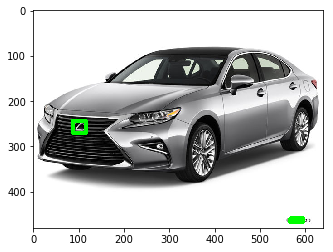

In [57]:
img_yo = cv2.imread('../data/test/sample_in/test9.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(567, 458, 596, 467), (87, 243, 116, 271)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

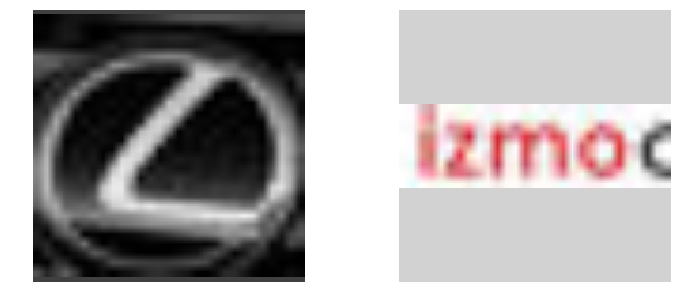

In [58]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

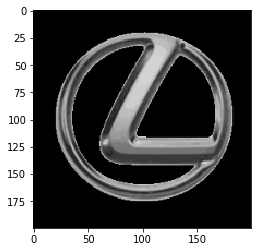

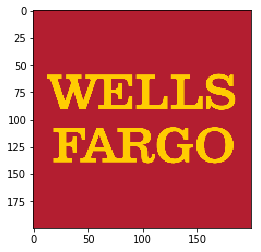

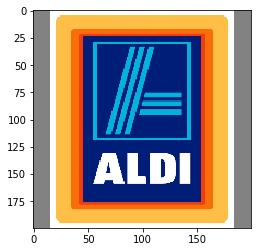

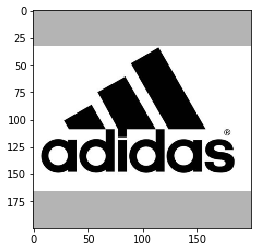

In [59]:
img_data = []
paths = ['test_lexus.png','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [60]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

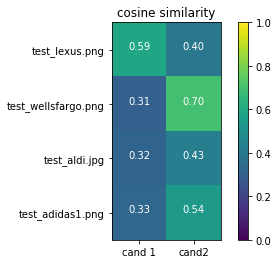

In [61]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand 3'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [62]:
cs1 = cosine_similarity(X = feat_input, Y = features)

test_lexus 95% level: 0.451
test_wellsfargo 95% level: 0.691
test_aldi 95% level: 0.487
test_adidas1 95% level: 0.555


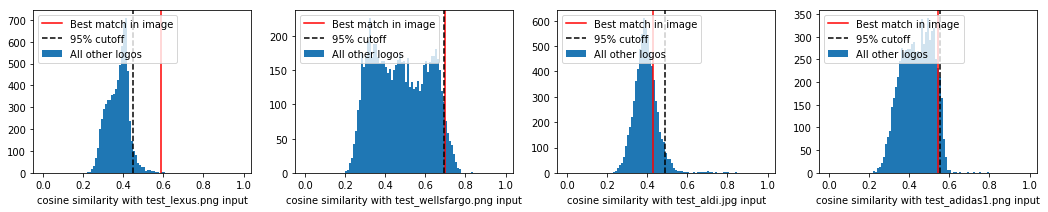

In [63]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos')
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image')
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))
    
    counts, bins = np.histogram(cs1[iax], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[iax])
    ax.axvline(bins[np.where(cdf < 0.95)][-1], c='k', ls='--', label='95% cutoff')
    print('{} 95% level: {:.3f}'.format(paths[iax].split('.')[0], bins[np.where(cdf < 0.95)][-1]))
    ax.legend(loc='upper left')


Again, we see that the correct Lexus logo sits at the end of the input distribution, while the other incorrect input candidates have cosine similarities in the bulk of the image.

We can also notice another thing: the cosine similarity of the second logo candidate is higher for other inputs than between Lexus and first logo. Absolute values of the cosine similarity are not good indicators, one should compare to **typical** values, which can be taken from the training data (the histograms above), and decide on a threshold

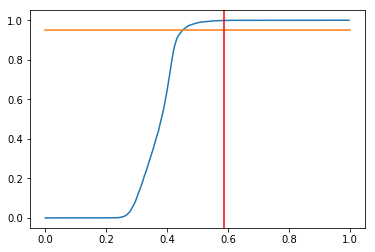

In [136]:
plt.plot(bins[:-1],cdf)
plt.plot((0,1),(0.95,0.95))
plt.axvline(np.max(cc[0]), c='r');

In [64]:
sim_cutoff, cdf_list = [], []
for i in range(len(feat_input)):
    counts, bins = np.histogram(cs1[i], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[i])
    cdf_list.append(cdf)
    sim_cutoff.append(bins[np.where(cdf < 0.95)][-1])

In [75]:
matches, cos_sim = similarity.similar_matches(feat_input, features_cand, sim_cutoff, bins, cdf_list)
matches

Found 2 logos from 2 classes


{0: (0, 0.9987482614742699), 1: (1, 0.9621696801112657)}

In [80]:
labels = [ path.split('.')[0].split('test_')[1] for path in paths]
new_img = similarity.draw_matches(img_yo, labels, bboxes[::-1], matches)

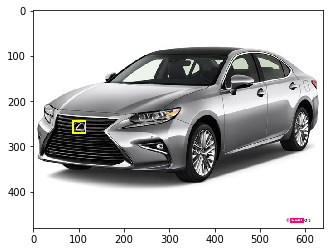

In [81]:
plt.imshow(new_img);

### duff
YOLO on test12.jpg:
```
logo 0.37 (258, 627) (470, 813)
logo 0.38 (299, 257) (404, 297)
logo 0.82 (513, 587) (695, 760)
logo 0.98 (67, 582) (241, 738)
```

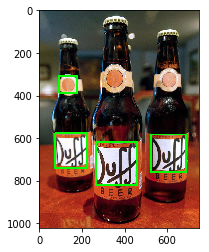

In [82]:
img_yo = cv2.imread('../data/test/sample_in/test12.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(94, 307, 178, 388), (265, 620, 461, 820), (525, 583, 688, 761),(74, 578, 223, 742)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

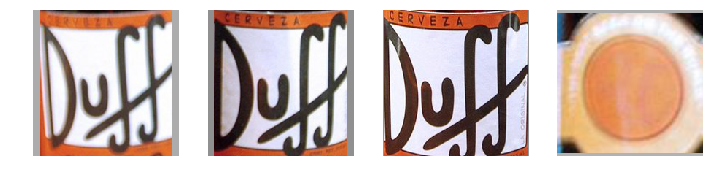

In [83]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

We will test these logos against the batman logo, the robin logo, and the in-set logos we had above

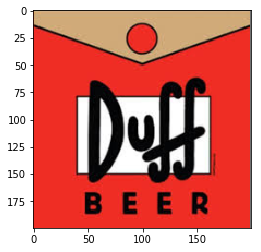

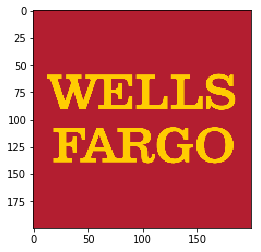

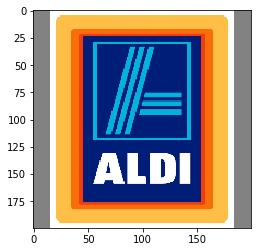

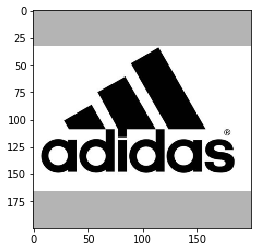

In [84]:
img_data = []
paths = ['test_duff.jpg','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [85]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

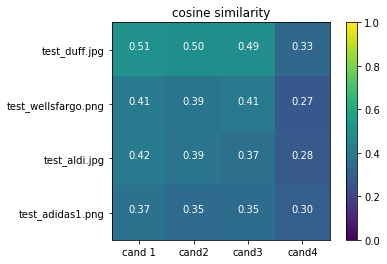

In [86]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand3','cand4'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [87]:
cs1 = cosine_similarity(X = feat_input, Y = features)

test_duff 95% level: 0.480
test_wellsfargo 95% level: 0.691
test_aldi 95% level: 0.487
test_adidas1 95% level: 0.555


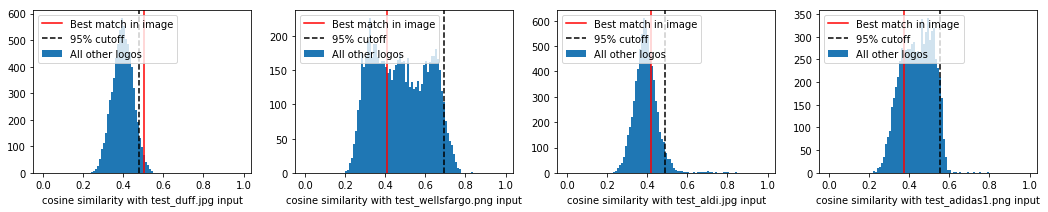

In [88]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos');
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image');
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))

    counts, bins = np.histogram(cs1[iax], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[iax])
    ax.axvline(bins[np.where(cdf < 0.95)][-1], c='k', ls='--', label='95% cutoff')
    print('{} 95% level: {:.3f}'.format(paths[iax].split('.')[0], bins[np.where(cdf < 0.95)][-1]))
    ax.legend(loc='upper left')

In [89]:
counts, bins = np.histogram(cs1[0], bins=np.arange(0,1,0.001))
cdf = np.cumsum(counts)/len(cs1[0])
print('Target 95% level: {:.3f}'.format(bins[np.where(cdf < 0.95)][-1]))

Target 95% level: 0.480


In [90]:
sim_cutoff, cdf_list = [], []
for i in range(len(feat_input)):
    counts, bins = np.histogram(cs1[i], bins=np.arange(0,1,0.001))
    cdf = np.cumsum(counts)/len(cs1[i])
    cdf_list.append(cdf)
    sim_cutoff.append(bins[np.where(cdf < 0.95)][-1])

In [91]:
matches, cos_sim = similarity.similar_matches(feat_input, features_cand, sim_cutoff, bins, cdf_list)
matches

Found 3 logos from 1 classes


{0: (0, 0.9841446453407511),
 1: (0, 0.9777468706536857),
 2: (0, 0.9652294853963839)}

In [92]:
labels = [ path.split('.')[0].split('test_')[1] for path in paths]
new_img = similarity.draw_matches(img_yo, labels, bboxes[::-1], matches)

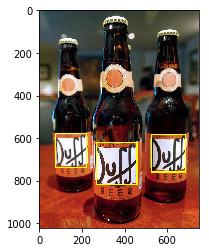

In [93]:
plt.imshow(new_img);